In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
train = pd.read_csv("train.csv")
train.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


In [6]:
test = pd.read_csv("test.csv")
test.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3


In [7]:
train.describe()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
count,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000,7111.000000
mean,20.878034,47.561004,1.110309,1091.572100,938.064970,883.903305,1513.238349,998.335565,2.086219,10.237083,204.066784
std,7.937917,17.398731,0.398950,218.537554,281.978988,310.456355,350.180310,381.537695,1.447109,7.694426,193.927723
min,1.300000,8.900000,0.198800,620.300000,364.000000,310.600000,552.900000,242.700000,0.100000,0.100000,1.900000
25%,14.900000,33.700000,0.855900,930.250000,734.900000,681.050000,1320.350000,722.850000,1.000000,4.500000,76.450000
50%,20.700000,47.300000,1.083500,1060.500000,914.200000,827.800000,1513.100000,928.700000,1.700000,8.500000,141.000000
75%,25.800000,60.800000,1.404150,1215.800000,1124.100000,1008.850000,1720.400000,1224.700000,2.800000,14.200000,260.000000
max,46.100000,90.800000,2.231000,2088.300000,2302.600000,2567.400000,2913.800000,2594.600000,12.500000,63.700000,1472.300000


In [9]:
def shift_feature(df):
    shift_features = ["deg_C", "absolute_humidity", "relative_humidity",
                      "sensor_1", "sensor_2", "sensor_3", "sensor_4", "sensor_5"]
    # Amounts of hour shifts and lags
    shifts = [1, 3]
    
    for feature in shift_features:
        for shift in shifts:
            df[feature+"-"+str(shift)+"abs_shfit"] = df[feature] - df[feature].shift(periods=shift, fill_value=0)
            df[feature+"+"+str(shift)+"abs_shfit"] = df[feature] - df[feature].shift(periods=-shift, fill_value=0)
            df[feature+"-"+str(shift)+"prc_shfit"] = (df[feature] / df[feature].shift(periods=shift, fill_value=0)) - 1
            df[feature+"+"+str(shift)+"prc_shfit"] = (df[feature] / df[feature].shift(periods=-shift, fill_value=0)) - 1

    # Replacing infinity values as a result of devision by zero at the end of a dataset
    df.replace(to_replace=np.inf, value=0, inplace=True)
    return df.drop("hour", axis=1)

In [10]:
def month(x):
    return int(x[5:7])
def hour(x):
    return int(x[11:13])
train['month'] = train['date_time'].apply(month)
train['hour'] = train['date_time'].apply(hour)
train["is_winter"] = train["month"].isin([1, 2, 12]).astype("int")
train["is_spring"] = train["month"].isin([3, 4, 5]).astype("int")
train["is_summer"] = train["month"].isin([6, 7, 8]).astype("int")
train["is_autumn"] = train["month"].isin([9, 10, 11]).astype("int")
train["working_hours"] =  train["hour"].isin(np.arange(8, 21, 1)).astype("int")
#train["maximum_hours"] =  train["hour"].isin([8, 9, 17, 18, 19, 20]).astype("int")
train['SMC'] = (train['absolute_humidity'] * 100) / train['relative_humidity']
train['Dew_Point'] = 243.12*(np.log(train['relative_humidity'] * 0.01) + (17.62 * train['deg_C'])/
                                (243.12+train['deg_C']))/(17.62-(np.log(train['relative_humidity'] * 0.01)
                                                                    +17.62*train['deg_C']/(243.12+train['deg_C'])))
train["is_weekend"] = (train["date_time"].apply(pd.to_datetime).dt.dayofweek >= 5).astype("int")
train["date_time"] = pd.to_datetime(train["date_time"], format="%Y-%m-%d %H:%M:%S")
#train = shift_feature(train)
#train.head()

In [12]:
train['week'] = train['date_time'].dt.isocalendar().week

/tmp/ipykernel_3204/2344230901.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),cmap = 'Accent_r')


<Axes: >

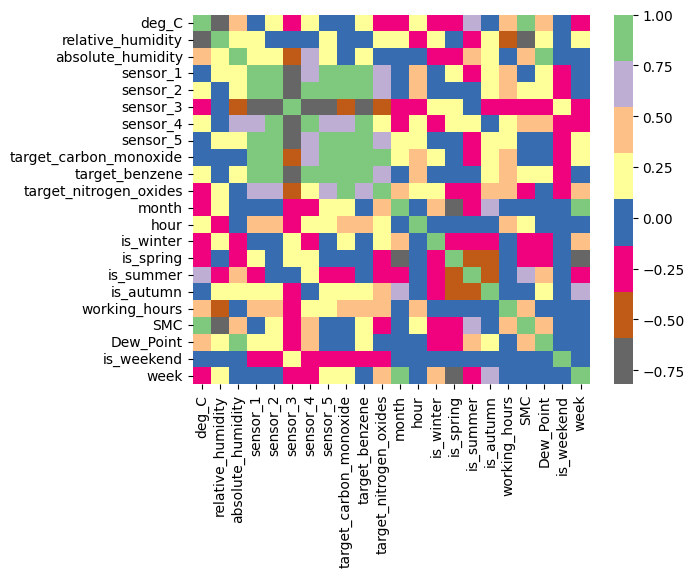

In [13]:
sns.heatmap(train.corr(),cmap = 'Accent_r')

/tmp/ipykernel_3204/900763268.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['target_carbon_monoxide'])


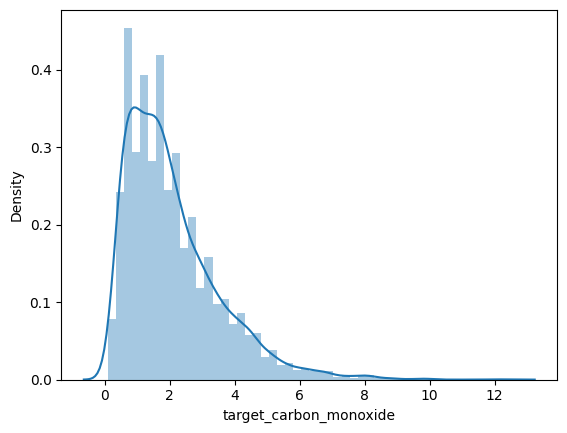

/tmp/ipykernel_3204/900763268.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log1p(train['target_carbon_monoxide']))


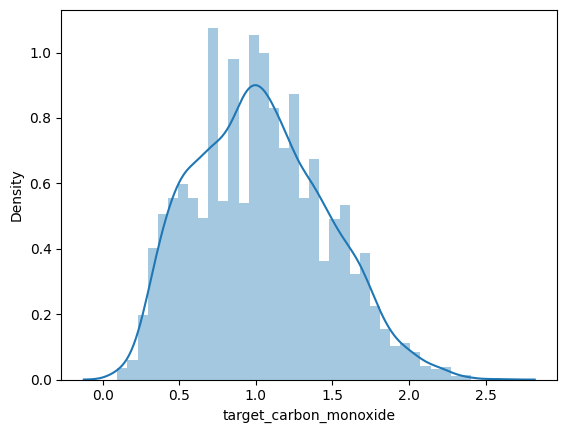

In [18]:
sns.distplot(train['target_carbon_monoxide'])
plt.show()
sns.distplot(np.log1p(train['target_carbon_monoxide']))
plt.show()

In [19]:
test['month'] = test['date_time'].apply(month)
test['hour'] = test['date_time'].apply(hour)
test["is_winter"] = test["month"].isin([1, 2, 12]).astype("int")
test["is_spring"] = test["month"].isin([3, 4, 5]).astype("int")
test["is_summer"] = test["month"].isin([6, 7, 8]).astype("int")
test["is_autumn"] = test["month"].isin([9, 10, 11]).astype("int")
test["working_hours"] =  test["hour"].isin(np.arange(8, 21, 1)).astype("int")
test["is_weekend"] = (test["date_time"].apply(pd.to_datetime).dt.dayofweek >= 5).astype("int")
test['SMC'] = (test['absolute_humidity'] * 100) / test['relative_humidity']
test['Dew_Point'] = 243.12*(np.log(test['relative_humidity'] * 0.01) + (17.62 * test['deg_C'])/
                                (243.12+test['deg_C']))/(17.62-(np.log(test['relative_humidity'] * 0.01)
                                                                    +17.62*test['deg_C']/(243.12+test['deg_C'])))
#test["maximum_hours"] =  test["hour"].isin([8, 9, 17, 18, 19, 20]).astype("int")
test["date_time"] = pd.to_datetime(test["date_time"], format="%Y-%m-%d %H:%M:%S")
#test['week'] = test['date_time'].dt.weekofyear
#test = shift_feature(test)
test_dt = test['date_time']
test.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,month,hour,is_winter,is_spring,is_summer,is_autumn,working_hours,is_weekend,SMC,Dew_Point
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1,1,0,1,0,0,0,0,1,1.059322,-4.376278
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0,1,1,1,0,0,0,0,1,0.882785,-4.039227
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8,1,2,1,0,0,0,0,1,0.910485,-3.441881
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0,1,3,1,0,0,0,0,1,0.897323,-3.978058
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3,1,4,1,0,0,0,0,1,0.808696,-3.175343


In [20]:
test.shape

(2247, 19)

In [21]:
Xtrain = train.drop(["date_time", 'target_carbon_monoxide', 'target_benzene', 
                     'target_nitrogen_oxides'], axis = 1)
y_co = np.log1p(train['target_carbon_monoxide'])
y_be = np.log1p(train['target_benzene'])
y_no = np.log1p(train['target_nitrogen_oxides'])
Xtrain

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,month,hour,is_winter,is_spring,is_summer,is_autumn,working_hours,SMC,Dew_Point,is_weekend,week
0,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,3,18,0,1,0,0,1,1.647391,1.727907,0,10
1,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,3,19,0,1,0,0,1,1.601545,1.604653,0,10
2,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,3,20,0,1,0,0,1,1.334875,4.095906,0,10
3,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,3,21,0,1,0,0,0,1.260737,4.084138,0,10
4,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,3,22,0,1,0,0,0,1.336949,4.133561,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7106,9.2,32.0,0.3871,1000.5,811.2,873.0,909.0,910.5,12,20,1,0,0,0,1,1.209688,-6.669204,0,52
7107,9.1,33.2,0.3766,1022.7,790.0,951.6,912.9,903.4,12,21,1,0,0,0,0,1.134337,-6.275931,0,52
7108,9.6,34.6,0.4310,1044.4,767.3,861.9,889.2,1159.1,12,22,1,0,0,0,0,1.245665,-5.290964,0,52
7109,8.0,40.7,0.4085,952.8,691.9,908.5,917.0,1206.3,12,23,1,0,0,0,0,1.003686,-4.570841,0,52


In [22]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(Xtrain)
Xtrain1 = ss.transform(Xtrain)

In [23]:
X_train, X_test, y_train_co, y_test_co = train_test_split(Xtrain1, 
                                                          y_co, test_size=0.33, random_state=44)

model_co = XGBRegressor(n_estimators=75,random_state=44)
model_co.fit(X_train,y_train_co)

pred = model_co.predict(X_test)
np.sqrt(mean_squared_log_error(y_test_co,pred))

0.056275372467488434

#Carbon Monoxide

In [24]:
from sklearn.model_selection import GridSearchCV
params = {'n_estimators' : [50, 75, 100, 125, 150]}
grid = GridSearchCV(XGBRegressor(random_state=44),params, verbose = 1)
grid.fit(X_train, y_train_co)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=44, ...),
             param_grid={'n_estimators': [50, 75, 100, 125, 150]}, verbose=1)

In [25]:
grid.best_params_
pred = grid.predict(X_test)
np.sqrt(mean_squared_log_error(y_test_co,pred))

0.056275372467488434

#Benzine

In [26]:
X_train, X_test, y_train_be, y_test_be = train_test_split(Xtrain1, 
                                                          y_be, test_size=0.33, random_state=44)

model_be = RandomForestRegressor(random_state=44)
model_be.fit(X_train,y_train_be)

pred = model_be.predict(X_test)
np.sqrt(mean_squared_log_error(y_test_be,pred))

0.03194790451519284

#Nitrogen Oxide

In [28]:
Xtrain2 = pd.concat([Xtrain, train['target_carbon_monoxide'],train['date_time'].dt.isocalendar().week],axis = 1)
Xtrain2.head()
ss2 = StandardScaler()
ss2.fit(Xtrain2)
Xtrain2 = ss2.transform(Xtrain2)

In [31]:
X_train, X_test, y_train_no, y_test_no = train_test_split(Xtrain2, 
                                                          y_no, test_size=0.33, random_state=44)

model_no = GradientBoostingRegressor(random_state=44)
model_no.fit(X_train,y_train_no)

pred = model_no.predict(X_test)
for i in range(len(pred)):
    if pred[i] < 0:
        pred[i] = 0
np.sqrt(mean_squared_log_error(y_test_no,pred))

0.03781265180523612

In [35]:
test1 = test.drop(['date_time'], axis = 1)
test1.shape
test1 = ss.transform(test1)
pred_co = model_co.predict(test1)
pred_be = model_be.predict(test1)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- week


In [ ]:
test2 = pd.concat([test.drop(['date_time'], axis = 1),test['date_time'].dt.weekofyear, pd.Series(pred_co)],axis = 1)
test2 = ss2.transform(test2)
pred_no = model_no.predict(test2)

#Inverse Transform

In [ ]:
pred_co_f = np.exp(pred_co)-1
pred_be_f = np.exp(pred_be)-1
pred_no_f = np.exp(pred_no)-1

In [ ]:
df = pd.DataFrame(test_dt)
df['target_carbon_monoxide'] = pred_co_f
df['target_benzene'] = pred_be_f
df['target_nitrogen_oxides'] = pred_no_f
df